![Semillero Astrofisica](../../logo.png)

---
# Operator Learning


Carlos Andrés del Valle (cdelv@unal.edu.co)

---

La versión superior de las Redes Neuronales Físicamente Informadas es el aprendizaje de operadores. Podemos enseñarle a la red un operador en vez de una ecuación, y con suerte, esta red será más flexible y precisa en sus predicciones. La siguiente charla ilustra muy bien estas redes

https://www.youtube.com/watch?v=QV1fVttZ6YE&t=3602s

Vamos a aprender el operador 
\begin{equation}
    G: v\to u
\end{equation}

definido como
\begin{equation}
    \frac{d}{dx}u(x)=v(x),\qquad x\in[0,1]
\end{equation}

con $u(0)=0$. Vamos a usar un set de datos $(u,v)$ del cuál se va a aprender el operador. En el siguiente link hay más detalles sobre este ejemplo y cómo se generó el set de datos
https://deepxde.readthedocs.io/en/latest/demos/operator/antiderivative_aligned.html.


In [1]:
import deepxde as dde
import matplotlib.pyplot as plt
import numpy as np

#Usar doble precisión si la GPU lo soporta. Float32 por defecto.
dde.config.real.set_float64()

Using backend: tensorflow.compat.v1

2022-11-13 12:26:29.300441: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-13 12:26:29.409735: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-11-13 12:26:29.413482: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-13 12:26:29.413495: I tensorflow/stream_executor/cuda/cudart_stub.cc:

Instructions for updating:
non-resource variables are not supported in the long term


Instructions for updating:
non-resource variables are not supported in the long term
2022-11-13 12:26:30.674511: E tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-11-13 12:26:30.674570: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (pop-os): /proc/driver/nvidia/version does not exist


## 1. Organizar el Set de Datos

- Las funciones $v(x)$ serán un array (mxn), con m el número de funciones y n es número de muestras de dicha función.

- La coordenada x será un array de tamaño n

- Las funciones $u(x)$ de también serán un array (mxn).

In [4]:
# Tenmos 150 funciones de entrenamiento
d = np.load("antiderivative_aligned_train.npz", allow_pickle=True)
X_train, y_train = (d["X"][0], d["X"][1]), d["y"]

# Tenemos 700 funciones de prueba
d = np.load("antiderivative_aligned_test.npz", allow_pickle=True)
X_test, y_test = (d["X"][0], d["X"][1]), d["y"]

## 2. Definir Datos de Entrenamiento

~~~python
class deepxde.data.triple.TripleCartesianProd(X_train, 
                                              y_train, 
                                              X_test, 
                                              y_test)
~~~

Dataset with each data point as a triple. The ordered pair of the first two elements are created from a Cartesian product of the first two lists. If we compute the Cartesian product of the first two arrays, then we have a Triple dataset.

This dataset can be used with the network DeepONetCartesianProd for operator learning.

**Parameters:**	
- **X_train** – A tuple of two NumPy arrays. The first element has the shape (N1, dim1), and the second element has the shape (N2, dim2).
- **y_train** – A NumPy array of shape (N1, N2).

https://deepxde.readthedocs.io/en/latest/modules/deepxde.data.html?highlight=data.TripleCartesianProd#deepxde.data.triple.TripleCartesianProd

In [5]:
data = dde.data.TripleCartesianProd(
    X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test
)

## 3. Crear la Red Neuronal

~~~ python
class deepxde.nn.tensorflow_compat_v1.deeponet.DeepONetCartesianProd(layer_size_branch, 
                                                                     layer_size_trunk, 
                                                                     activation, 
                                                                     kernel_initializer, 
                                                                     regularization=None)
~~~

**Cuidado: Hay diferentes implementaciones para cada backend!!**

https://deepxde.readthedocs.io/en/latest/modules/deepxde.nn.tensorflow_compat_v1.html?highlight=DeepONetCartesianProd#deepxde.nn.tensorflow_compat_v1.deeponet.DeepONetCartesianProd

In [6]:
m = 100
dim_x = 1
net = dde.nn.DeepONetCartesianProd(
    [m, 40, 40],
    [dim_x, 40, 40],
    "relu",
    "Glorot normal",
)

## 4. Compilar y Entrenar el Modelo 

In [7]:
model = dde.Model(data, net)
model.compile("adam", lr=0.001, metrics=["mean l2 relative error"])
losshistory, train_state = model.train(iterations=10000)

Compiling model...
Building DeepONetCartesianProd...
'build' took 0.038807 s

'compile' took 0.135794 s

Initializing variables...
Training model...



/home/wind/.local/lib/python3.10/site-packages/deepxde/nn/tensorflow_compat_v1/deeponet.py:312: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  y_func = tf.layers.dense(
/home/wind/.local/lib/python3.10/site-packages/deepxde/nn/tensorflow_compat_v1/deeponet.py:319: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  y_func = tf.layers.dense(
/home/wind/.local/lib/python3.10/site-packages/deepxde/nn/tensorflow_compat_v1/deeponet.py:331: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  y_loc = tf.layers.dense(
2022-11-13 15:00:48.016456: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:

Step      Train loss    Test loss     Test metric   
0         [3.35e-01]    [4.07e-01]    [1.11e+00]    
1000      [1.70e-04]    [1.86e-04]    [4.97e-02]    
2000      [3.27e-05]    [4.42e-05]    [2.61e-02]    
3000      [2.12e-05]    [2.87e-05]    [2.13e-02]    
4000      [1.68e-05]    [2.29e-05]    [1.93e-02]    
5000      [1.51e-05]    [2.06e-05]    [1.83e-02]    
6000      [1.33e-05]    [1.86e-05]    [1.75e-02]    
7000      [1.78e-05]    [2.29e-05]    [1.78e-02]    
8000      [1.49e-05]    [1.94e-05]    [1.73e-02]    
9000      [9.00e-06]    [1.46e-05]    [1.53e-02]    
10000     [6.62e-06]    [1.20e-05]    [1.39e-02]    

Best model at step 10000:
  train loss: 6.62e-06
  test loss: 1.20e-05
  test metric: [1.39e-02]

'train' took 7.555682 s



## 7. Visualizar la Solución

Error: The network has multiple inputs, and plotting such result han't been implemented.


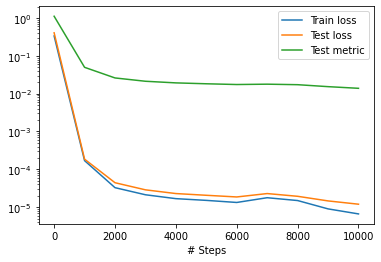

In [8]:
dde.saveplot(losshistory, train_state, issave=False, isplot=True) 